In [1]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
import pandas as pd
import numpy as np
import os
import random
from collections import defaultdict, Counter
from itertools import combinations
import json
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
import optuna
# from torchmetrics.classification import F1Score
import pickle
import sys
### import Dataset prepartion and model training classes from BS_LS_scripts folder
sys.path.insert(1, '/home/wangc90/circRNA/circRNA_Data/BS_LS_scripts/')
from BS_LS_DataSet import BS_LS_DataSet_Prep, BS_LS_upper_lower_rcm
# from BS_LS_Training_Best_Base_model2 import Objective, Objective_CV
from PPM_extraction import PPM_extraction

random.seed(2023)
torch.manual_seed(2023)

In [2]:
### Model 2 input sequence 4 X 200 + 4 X 200 with 1 or 2CNN layer
class Model2_optuna_upper_9000(nn.Module):
    '''
        This is for 2-d model to process the upper half of the sequence with 1 or 2 CNN
    '''

    def __init__(self, trial):
        super(Model2_optuna_upper_9000, self).__init__()
        # convlayer 1
#         self.out_channel1 = trial.suggest_categorical('upper_out_channel1', [128, 256, 512])
        self.out_channel1 = 512
#         kernel_size1 = trial.suggest_categorical('upper_kernel_size1', [13, 15, 17, 19, 21])
        kernel_size1 = 21

        self.conv1 = nn.Conv1d(in_channels=4, out_channels=self.out_channel1, \
                               kernel_size=kernel_size1, stride=1, padding=(kernel_size1 - 1) // 2)
        self.conv1_bn = nn.BatchNorm1d(self.out_channel1)
#         self.maxpool1 = trial.suggest_categorical('upper_maxpool1', [5, 10, 20])
        self.maxpool1 = 5
        self.conv1_out_dim = 200 // self.maxpool1

#         self.out_channel2 = trial.suggest_categorical('upper_out_channel2', [128, 256, 512])
        self.out_channel2 = 512
#         kernel_size2 = trial.suggest_categorical('upper_kernel_size2', [13, 15, 17, 19, 21])
        kernel_size2 = 21

        self.conv2 = nn.Conv1d(in_channels=self.out_channel1, out_channels=self.out_channel2, \
                               kernel_size=kernel_size2, stride=1, padding=(kernel_size2 - 1) // 2)
        self.conv2_bn = nn.BatchNorm1d(self.out_channel2)
#         self.maxpool2 = trial.suggest_categorical('upper_maxpool2', [5, 10])
        self.maxpool2 = 10
        self.conv2_out_dim = 200 // (self.maxpool1 * self.maxpool2)

    def forward(self, x):
        out = x
        out = torch.relu(self.conv1_bn(self.conv1(out)))
        out = F.max_pool1d(out, self.maxpool1)
        out = torch.relu(self.conv2_bn(self.conv2(out)))
        out = F.max_pool1d(out, self.maxpool2)
        out = out.view(-1, self.out_channel2 * self.conv2_out_dim)
        return out


class Model2_optuna_lower_9000(nn.Module):
    '''
        This is for 2-d model to process the upper half of the sequence with 1 or 2 CNN
    '''

    def __init__(self, trial):

        super(Model2_optuna_lower_9000, self).__init__()
        # convlayer 1
#         self.out_channel1 = trial.suggest_categorical('lower_out_channel1', [128, 256, 512])
        self.out_channel1 = 512
#         kernel_size1 = trial.suggest_categorical('lower_kernel_size1', [13, 15, 17, 19, 21])
        kernel_size1 = 13
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=self.out_channel1, \
                               kernel_size=kernel_size1, stride=1, padding=(kernel_size1 - 1) // 2)
        self.conv1_bn = nn.BatchNorm1d(self.out_channel1)
#         self.maxpool1 = trial.suggest_categorical('lower_maxpool1', [5, 10, 20])
        self.maxpool1 = 5
        self.conv1_out_dim = 200 // self.maxpool1

#         self.out_channel2 = trial.suggest_categorical('lower_out_channel2', [128, 256, 512])
        self.out_channel2 = 512
#         kernel_size2 = trial.suggest_categorical('lower_kernel_size2', [13, 15, 17, 19, 21])
        kernel_size2 = 21
        self.conv2 = nn.Conv1d(in_channels=self.out_channel1, out_channels=self.out_channel2, \
                               kernel_size=kernel_size2, stride=1, padding=(kernel_size2 - 1) // 2)
        self.conv2_bn = nn.BatchNorm1d(self.out_channel2)
#         self.maxpool2 = trial.suggest_categorical('lower_maxpool2', [5, 10])
        self.maxpool2 = 10
        self.conv2_out_dim = 200 // (self.maxpool1 * self.maxpool2)

    def forward(self, x):
        out = x
        out = torch.relu(self.conv1_bn(self.conv1(out)))
        out = F.max_pool1d(out, self.maxpool1)
        out = torch.relu(self.conv2_bn(self.conv2(out)))
        out = F.max_pool1d(out, self.maxpool2)
        out = out.view(-1, self.out_channel2 * self.conv2_out_dim)
        return out

    
class ConcatModel2_optuna_9000(nn.Module):
    def __init__(self, trial):

        super(ConcatModel2_optuna_9000, self).__init__()
        ### cnn for the upper half sequence
        self.cnn_upper = Model2_optuna_upper_9000(trial)

        # this is for two convlayer
        self.upper_out_dim = self.cnn_upper.conv2_out_dim
        self.upper_out_channel = self.cnn_upper.out_channel2

        ### cnn for the lower half sequence
        self.cnn_lower = Model2_optuna_lower_9000(trial)

            # this is for two convlayer
        self.lower_out_dim = self.cnn_lower.conv2_out_dim
        self.lower_out_channel = self.cnn_lower.out_channel2

        self.upper_lower_concate_fc1_in = self.upper_out_channel * self.upper_out_dim + \
                                 self.lower_out_channel * self.lower_out_dim

#         self.upper_lower_concate_fc1_out = trial.suggest_categorical('concat_fc1_out', [128, 256, 512])
        self.upper_lower_concate_fc1_out = 128

        self.upper_lower_concate_fc1 = nn.Linear(self.upper_lower_concate_fc1_in, self.upper_lower_concate_fc1_out)

        self.upper_lower_concate_fc1_bn = nn.BatchNorm1d(self.upper_lower_concate_fc1_out)

#         dropout_rate_fc1 = trial.suggest_categorical("concat_dropout_rate_fc1",  [0, 0.1, 0.2, 0.4])
        dropout_rate_fc1 = 0.2
        self.drop_nn1 = nn.Dropout(p=dropout_rate_fc1)

        # fc layer2
        # use dimension output with nn.CrossEntropyLoss()
#         self.upper_lower_concate_fc2_out = trial.suggest_categorical('concat_fc2_out', [4, 8, 16, 32])
        self.upper_lower_concate_fc2_out = 4
        self.upper_lower_concate_fc2 = nn.Linear(self.upper_lower_concate_fc1_out, self.upper_lower_concate_fc2_out)
        self.upper_lower_concate_fc2_bn = nn.BatchNorm1d(self.upper_lower_concate_fc2_out)

#         dropout_rate_fc2 = trial.suggest_categorical("concat_dropout_rate_fc2", [0, 0.1, 0.2, 0.4])
        dropout_rate_fc2 = 0.1
        self.drop_nn2 = nn.Dropout(p=dropout_rate_fc2)

        self.upper_lower_concate_final = nn.Linear(self.upper_lower_concate_fc2_out, 2)

        
    def forward(self, seq_upper_feature, seq_lower_feature):

        # obatin the result from the cnn upper
        x1 = self.cnn_upper(seq_upper_feature)

        # obtain the result from the cnn lower
        x2 = self.cnn_lower(seq_lower_feature)

        x = torch.cat((x1, x2), dim=1)

        # feed the concatenated feature to fc1
        out = self.upper_lower_concate_fc1(x)
        out = self.drop_nn1(torch.relu(self.upper_lower_concate_fc1_bn(out)))

        out = self.upper_lower_concate_fc2(out)
        out = self.drop_nn2(torch.relu(self.upper_lower_concate_fc2_bn(out)))

        out = self.upper_lower_concate_final(out)

        return out


In [3]:
ConcatModel2_optuna_9000_ = ConcatModel2_optuna_9000('trial')

In [4]:
ConcatModel2_optuna_9000_

ConcatModel2_optuna_9000(
  (cnn_upper): Model2_optuna_upper_9000(
    (conv1): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=(10,))
    (conv1_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(512, 512, kernel_size=(21,), stride=(1,), padding=(10,))
    (conv2_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_lower): Model2_optuna_lower_9000(
    (conv1): Conv1d(4, 512, kernel_size=(13,), stride=(1,), padding=(6,))
    (conv1_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(512, 512, kernel_size=(21,), stride=(1,), padding=(10,))
    (conv2_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (upper_lower_concate_fc1): Linear(in_features=4096, out_features=128, bias=True)
  (upper_lower_concate_fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [8]:
def retraining(model, dataset, model_folder):
    
    device = torch.device('cuda:1') if torch. cuda.is_available() else torch.device('cpu')
    
    batch_size = 32
    
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#     print(len(train_loader))

    criterion = nn.CrossEntropyLoss()
    
    model = model('trial').to(device=device)
    
    optimizer_name = 'Adam'
    lr = 0.00027347047353796394
    l2_lambda = 3.3988902171269707e-07
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=l2_lambda)
    
    epochs = 90 ### reduce the epochs from 150 to 100 to reduce the potential overfitting
    
    for epoch in range(epochs):
        #         print(f"I'am in the epoch {epoch}")
        model.train()
        # record the training loss
        running_loss = 0.0

        ## deal with different number of features in different dataset with star* notation
        for *features, train_labels in train_loader:
            ### this line is just for nn.CrossEntropy loss otherwise can be safely removed
            train_labels = train_labels.type(torch.LongTensor)

            train_labels = train_labels.to(device)
            features = [i.to(device) for i in features]

            # forward pass
            train_preds = model(*features)
            loss = criterion(train_preds, train_labels)
            # backward pass
            optimizer.zero_grad()  # empty the gradient from last round

            # calculate the gradient
            loss.backward()
            # update the parameters
            optimizer.step()
            running_loss += loss.item()

        #         print(f"I'am finished the epoch {epoch} training")
        ## start model validation

        model.eval()
        with torch.no_grad():
            # first evaluate the training acc ## don't need to evaluate the training acc
            correct, total = 0.0, 0.0
            for *features, train_labels in train_loader:
                ### this type conversion is just used for nn.CrossEntropy loss
                ### otherwise can be safely removed
                train_labels = train_labels.to(device)
                features = [i.to(device) for i in features]
            
                # get the predition with the model parameters updated after each epoch
                preds = model(*features)
                # prediction for the nn.CrossEntropy loss
                _, preds_labels = torch.max(preds, 1)
                correct += (preds_labels == train_labels).sum().item()
                total += train_labels.shape[0]
            
            train_acc = round(correct / total, 4)
            
        print(f"I'am finished the epoch {epoch} evaluation on the training set")
            
        if (epoch + 1) % 50 == 0:
            print(f'epoch {epoch + 1}, training loss {running_loss}, train accuracy {train_acc}')
    
    # save the model at the end of 150 epochs
    model_path = f"{model_folder}/retrained_model_{epoch}.pt"
    torch.save(model, model_path)


In [9]:
def base_model2_9000_retraining():
    
    ### where to save the retrained model
    model_folder = '/home/wangc90/circRNA/circRNA_Data/model_outputs/Base_model2_retraining/Base_model2_retraining_9000'

    ## These need to be changed for redhawks
    BS_LS_coordinates_path = '/home/wangc90/circRNA/circRNA_Data/BS_LS_data/updated_data/BS_LS_coordinates_final.csv'
    hg19_seq_dict_json_path = '/home/wangc90/circRNA/circRNA_Data/hg19_seq/hg19_seq_dict.json'
    flanking_dict_folder = '/home/wangc90/circRNA/circRNA_Data/BS_LS_data/flanking_dicts/'
    bs_ls_dataset = BS_LS_DataSet_Prep(BS_LS_coordinates_path=BS_LS_coordinates_path,
                                       hg19_seq_dict_json_path=hg19_seq_dict_json_path,
                                       flanking_dict_folder=flanking_dict_folder,
                                       flanking_junction_bps=100,
                                       flanking_intron_bps=100,
                                       training_size=9000)


    bs_ls_dataset.get_junction_flanking_intron_seq()

    ### use the 10000 for training RCM and junction seq and use 1000 for combine them
    train_key1, _, test_keys = bs_ls_dataset.get_train_test_keys()


    rcm_scores_folder = '/home/wangc90/circRNA/circRNA_Data/BS_LS_data/flanking_dicts/rcm_scores/'

    ## try without rcm features
    train_torch_upper_features, train_torch_lower_features, \
    train_torch_labels = bs_ls_dataset.seq_to_tensor(data_keys=train_key1, rcm_folder=rcm_scores_folder, is_rcm=False,
                                                     is_upper_lower_concat=False)

    BS_LS_dataset = BS_LS_upper_lower_rcm(include_rcm=False,
                                          seq_upper_feature=train_torch_upper_features,
                                          seq_lower_feature=train_torch_lower_features,
                                          flanking_rcm=None,
                                          upper_rcm=None,
                                          lower_rcm=None,
                                          label=train_torch_labels)

    print(len(BS_LS_dataset))

    retraining(model=ConcatModel2_optuna_9000, dataset=BS_LS_dataset,model_folder=model_folder)


In [10]:
base_model2_9000_retraining()

chr5|138837130|138837392|- has N in the extracted junctions, belongs to BS
There are 0 overlapped flanking sequence from BS and LS  
There are 7 repeated BS sequences
There are 2 repeated LS sequences
18000
I'am finished the epoch 0 evaluation on the training set
I'am finished the epoch 1 evaluation on the training set
I'am finished the epoch 2 evaluation on the training set
I'am finished the epoch 3 evaluation on the training set
I'am finished the epoch 4 evaluation on the training set
I'am finished the epoch 5 evaluation on the training set
I'am finished the epoch 6 evaluation on the training set
I'am finished the epoch 7 evaluation on the training set
I'am finished the epoch 8 evaluation on the training set
I'am finished the epoch 9 evaluation on the training set
I'am finished the epoch 10 evaluation on the training set
I'am finished the epoch 11 evaluation on the training set
I'am finished the epoch 12 evaluation on the training set
I'am finished the epoch 13 evaluation on the trai

In [11]:
## These need to be changed for redhawks
BS_LS_coordinates_path = '/home/wangc90/circRNA/circRNA_Data/BS_LS_data/updated_data/BS_LS_coordinates_final.csv'
hg19_seq_dict_json_path = '/home/wangc90/circRNA/circRNA_Data/hg19_seq/hg19_seq_dict.json'
flanking_dict_folder = '/home/wangc90/circRNA/circRNA_Data/BS_LS_data/flanking_dicts/'
bs_ls_dataset = BS_LS_DataSet_Prep(BS_LS_coordinates_path=BS_LS_coordinates_path,
                                   hg19_seq_dict_json_path=hg19_seq_dict_json_path,
                                   flanking_dict_folder=flanking_dict_folder,
                                   flanking_junction_bps=100,
                                   flanking_intron_bps=100,
                                   training_size=10000)


### generate the junction and flanking intron dict
bs_ls_dataset.get_junction_flanking_intron_seq()

### use the 10000 for training RCM and junction seq and use 1000 for combine them
train_key1, _, test_keys = bs_ls_dataset.get_train_test_keys()


rcm_scores_folder = '/home/wangc90/Desktop/project_data/flanking_dicts/rcm_scores/'



test_torch_upper_features, test_torch_lower_features, \
test_torch_labels = bs_ls_dataset.seq_to_tensor(data_keys=test_keys, rcm_folder=rcm_scores_folder, is_rcm=False,
                                                 is_upper_lower_concat=False)

BS_LS_dataset = BS_LS_upper_lower_rcm(include_rcm=False,
                                      seq_upper_feature=test_torch_upper_features,
                                      seq_lower_feature=test_torch_lower_features,
                                      flanking_rcm=None,
                                      upper_rcm=None,
                                      lower_rcm=None,
                                      label=test_torch_labels)

len(BS_LS_dataset)

chr5|138837130|138837392|- has N in the extracted junctions, belongs to BS
There are 0 overlapped flanking sequence from BS and LS  
There are 7 repeated BS sequences
There are 2 repeated LS sequences


2216

In [12]:
def Model_eva(model_path, test_data_set):
    
    '''
    ### load the saved best model and do the evaluation on the independent test dataset

    '''
    saved_model = torch.load(model_path).to('cuda')

    saved_model.eval()

    # test_data_set = torch.utils.data.Subset(BS_LS_test_dataset)

    data_loader = DataLoader(test_data_set, batch_size=100)

    with torch.no_grad():

        all_test_labels = []
        all_preds_prob = []

        correct, total = 0.0, 0.0
        for *test_features, test_labels in data_loader:
            #### change it to cuda:1 when evaluation for rcm models
            test_labels = test_labels.type(torch.LongTensor).to('cuda')
            test_features = [i.to('cuda') for i in test_features]

            preds = saved_model(*test_features)
            ## get the predited probability
            preds_prob = F.softmax(preds, dim=1)[:, 1]

            _, preds_labels = torch.max(preds, 1)
            correct += (preds_labels == test_labels).sum().item()
            total += test_labels.shape[0]

            all_test_labels.extend(test_labels.cpu().numpy().tolist())
            all_preds_prob.extend(preds_prob.cpu().numpy().tolist())

        val_acc = round(correct / total, 4)

        print(val_acc)
        
    return torch.from_numpy(np.array(all_test_labels)), torch.from_numpy(np.array(all_preds_prob))

In [13]:
model2_test_labels, model2_preds_prob = Model_eva(model_path='/home/wangc90/circRNA/circRNA_Data/model_outputs/Base_model2_retraining/Base_model2_retraining_9000/retrained_model_89.pt',\
                                                  test_data_set=BS_LS_dataset)

0.875


### bring in the best trained base model2 and get the intermediate value after first CNN layer with forward hook

trial0  0.868   0.879   0.8625  0.858   0.8735  0.8605  0.871   0.872   0.872   0.854 <br>
trial1  0.8665  0.868   0.87    0.851   0.8715  0.877   0.854   0.877   0.866   0.8635 <br>
trial2  0.8535  0.875   0.8565  0.853   0.862   0.8775  0.877   0.885   0.852   0.861 <br>

Trial2 fold 8 is the best for the best trained model2

In [7]:
### https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254
### https://github.com/uci-cbcl/DanQ/issues/9

### lower kernel 4 X 15 , padding 7

model_path = "/home/wangc90/circRNA/circRNA_Data/model_outputs/Best_Base_model2/models/fold8_trial2.pt"

ppm_extraction_BS_lower = PPM_extraction(train_instances='BS', train_key=train_key_1, is_upper=False,
                                         is_lower=True,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=7,
                               kernel_len=15, ppm_file_name='Best_base_model2_BS_lower_kernel_512_PPM')

ppm_extraction_BS_lower.write_out_PPM()

In [10]:
# ppm_extraction_BS_lower.subseq_starting_index_all_kernel[0]

In [11]:
# ppm_extraction_BS_lower.BS_lower_seqs

In [12]:
### upper kernel 4 X 17, padding 8
ppm_extraction_BS_upper = PPM_extraction(train_instances='BS', train_key=train_key_1, is_upper=True,
                                         is_lower=False,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=8,
                               kernel_len=17, ppm_file_name='Best_base_model2_BS_upper_kernel_512_PPM')
ppm_extraction_BS_upper.write_out_PPM()

In [13]:
ppm_extraction_LS_lower = PPM_extraction(train_instances='LS', train_key=train_key_1, is_upper=False,
                                         is_lower=True,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=7,
                               kernel_len=15, ppm_file_name='Best_base_model2_LS_lower_kernel_512_PPM')

ppm_extraction_LS_lower.write_out_PPM()

In [14]:
# ppm_extraction_LS_lower.BS_lower_seqs

In [15]:
ppm_extraction_LS_upper = PPM_extraction(train_instances='LS', train_key=train_key_1, is_upper=True,
                                         is_lower=False,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=8,
                               kernel_len=17, ppm_file_name='Best_base_model2_LS_upper_kernel_512_PPM')
ppm_extraction_LS_upper.write_out_PPM()

### Make some motif density plots

In [16]:
%load_ext rpy2.ipython


First compare motifs distribution of the BS and LS for the same Upper or Lower CNN structure

In [17]:
def activation_density_df_base_model2(is_upper, LS_kernel_num, BS_kernel_num):
    
    '''
        This function takes in a specific kernel num 0-511 for LS and BS that
        have same discovered motif and plot there density along the input sequence length
    '''
    if is_upper:
        ## compare the motif distribution for BS and LS in the upper sequence
    
        LS_activation_list = ppm_extraction_LS_upper.subseq_starting_index_all_kernel[LS_kernel_num].copy()
        BS_activation_list = ppm_extraction_BS_upper.subseq_starting_index_all_kernel[BS_kernel_num].copy()
    else:
        ## compare the motif distribution for BS and LS in the lower sequence
        LS_activation_list = ppm_extraction_LS_lower.subseq_starting_index_all_kernel[LS_kernel_num].copy()
        BS_activation_list = ppm_extraction_BS_lower.subseq_starting_index_all_kernel[BS_kernel_num].copy()        
    
    ## check if the two list have the same length before put them in a dataframe
    LS_activation_series = pd.Series(LS_activation_list, name='LS')
    BS_activation_series = pd.Series(BS_activation_list, name='BS')
    
    ## get the long df form with melt setting the grouping variables "LS" and "BS"
    df = pd.concat([LS_activation_series, BS_activation_series], axis=1).melt()
    
    ## drop the missing values (the instances where activation values are non positive)
    
    df_ = df.dropna()
    return df_

In [19]:
%%R
library("ggplot2")
library("RColorBrewer")

In [176]:
max_activation_df = activation_density_df_base_model2(is_upper=False, LS_kernel_num=359, BS_kernel_num=359)

In [177]:
%%R -i max_activation_df -o Fig1

My_Theme = theme(
  axis.title.x = element_text(size = 14),
  axis.text.x = element_text(size = 14),
  axis.title.y = element_text(size = 12),
  axis.text.y = element_text(size = 14))


Fig1 <- ggplot(max_activation_df, aes(x=value, color=variable)) + geom_density(size=1) +
    geom_vline(xintercept=100, linetype="dashed", color="red", size=1) + 
    xlim(c(0, 200)) +

    annotate("text", x=100, y=0, label= "SRSF9", size=8) +
    scale_color_manual(values=c("#999999", "#E69F00")) + 
    xlab('Sequence length (bp)') + ylab('Density') +
    labs(color='Splicing Types') +
    theme_bw() + My_Theme 

Fig1

ggsave(file=file.path('/home/wangc90/circRNA/circRNA_Data/model_outputs/Extracted_motifs/Motif_density_plot/', 'Best_base2_lower_SRSF9_2.svg'),
       width=5, height=4)

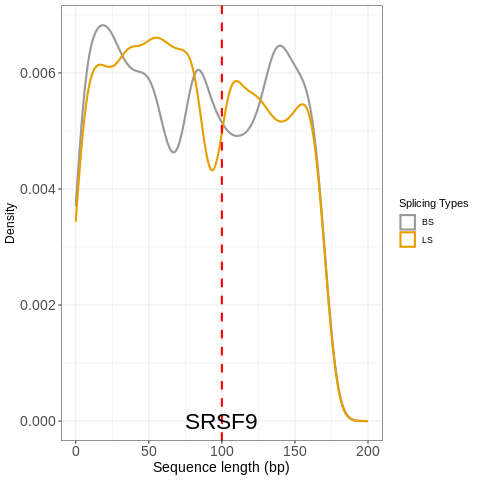

In [178]:
%%R
Fig1

In [ ]:
# %%R -i max_activation_df -o Fig1

# My_Theme = theme(
#   axis.title.x = element_text(size = 14),
#   axis.text.x = element_text(size = 14),
#   axis.title.y = element_text(size = 12),
#   axis.text.y = element_text(size = 14))


# Fig1 <- ggplot(max_activation_df, aes(x=value, color=variable)) + geom_density(size=1) +
#     geom_vline(xintercept=100, linetype="dashed", color="red", size=1) + 
#     geom_vline(xintercept=300, linetype="dashed", color="red", size=1) +
#     xlim(c(0, 400)) + 
#     annotate("text", x=200, y=0, label= "SRSF1", size=8) +
#     scale_color_manual(values=c("#999999", "#E69F00")) + 
#     xlab('Sequence length (bp)') + ylab('Density') +
#     labs(color='Splicing Types') +
#     theme_bw() + My_Theme 

# # Fig1

# ggsave(file=file.path('/home/wangc90/circRNA/circRNA_Data/model_outputs/Extracted_motifs/Motif_density_plot/', 'Best_base1_SRSF1_5.svg'),
#        width=5, height=4)